# Run Q3Dfit from this Jupyter Notebook in Astroconda Environment.

## Step 1: Create Initialization File. 

### Adjust it everywhere, where you see the commented line "These/This are/is unique to the user"!

In [1]:
%%writefile /Users/caroline/Documents/ARI-Heidelberg/Q3D/QUESTFIT/q3dfit/init/pg1411_and_Spitzer.py
#%%writefile /Users/dwylezal/EmmyNoether_Science/Q3D/JWST_ERS_Planning/Software/q3dfit/init/pg1411.py
# This is unique to the user, save file to /Your/Path/q3dfit/init/

import os.path
import numpy as np

# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')
from q3dfit.common import questfit_readcf


# This is unique to the user, name the function after your object. 
def pg1411_and_Spitzer():

    # These are unique to the user
    # bad=1e99
    gal = 'pg1411'
    outstr = 'rb3'
    ncols = 17
    nrows = 26
    # centcol = 9.002
    # centrow = 14.002
    platescale = 0.3
    fitrange = [4620,7450]

    
    #   These are unique to the user
    # volume = '/Users/dwylezal/EmmyNoether_Science/Q3D/JWST_ERS_Planning/Software/PG1411/'
    volume = '/Users/caroline/Documents/ARI-Heidelberg/Q3D/PG1411/pg1411/'
    infile = volume+gal+outstr+'.fits'
    mapdir = volume+gal+'/'+outstr+'/'
    outdir = volume+gal+'/'+outstr+'/'
    qsotemplate = volume+gal+'qsotemplate.npy'
    stellartemplates =  \
        volume+gal+'hosttemplate.npy'
    logfile = outdir+gal+'_fitlog.txt'
    #batchfile = '/Users/dwylezal/ESO_Fellowship/JWST_ERS_Planning/Software/ifsfit-master/common/fitloop.pro'
    #batchdir = '/Users/dwylezal/ESO_Fellowship/JWST_ERS_Planning/Software/'
    batchfile = '/Users/caroline/Documents/ARI-Heidelberg/Q3D/IFSFIT/ifsfit/common/ifsf_fitloop.pro'
    batchdir = '/Users/caroline/Documents/ARI-Heidelberg/Q3D/IFSFIT/'
    
    
    ### for our test object, pg1411, nothing needs to be changed here for now, make more flexible later
    
    #   These are unique to the user
    #  Include Spitzer source (independently of PG1411 for now for testing purposes)
    global_extinction = True
    global_ice_model = 'ice_hc'
    global_ext_model = 'CHIAR06'
    directory = '../test/test_questfit/'
    MIRcffile = '../test/test_questfit/IRAS21219m1757_dlw_qst.cf'
    config_file = questfit_readcf.readcf(MIRcffile)
    MIRz=0.112
    data_to_fit = np.load(directory+config_file['source'][0],allow_pickle=True)[0]
    wave = data_to_fit['WAVE'].astype('float')
    wave_min = np.where(wave>=float(config_file['source'][1]))[0][0]  # TO DO: Automise min/max wavelength
    wave_max = np.where(wave>=float(config_file['source'][2]))[0][0]
    wave = data_to_fit['WAVE'].astype('float')[wave_min:wave_max]
    flux = data_to_fit['FLUX'].astype('float')[wave_min:wave_max]
    weights = data_to_fit['stdev'].astype('float')[wave_min:wave_max]


    
    # Required parameters

    if not os.path.isfile(infile): print('Data cube not found.')

    # Lines to fit.
    lines = ['Halpha','Hbeta', '[OI]6300','[OI]6364','[OIII]4959','[OIII]5007', '[NII]6548','[NII]6583','[SII]6716','[SII]6731']
    # nlines = len(lines)

    # Max no. of components.
    maxncomp = 1

    # Initialize line ties, n_comps, z_inits, and sig_inits.
    linetie = dict()
    ncomp = dict()
    zinit_gas = dict()
    siginit_gas = dict()
    for i in lines:
        linetie[i] = 'Halpha'
        ncomp[i] = np.full((ncols,nrows),maxncomp)
        ncomp[i][8,13] = 0
        zinit_gas[i] = np.full((ncols,nrows,maxncomp),0.0898)
        siginit_gas[i] = np.full(maxncomp,50)
        zinit_gas[i][2,18,:]=0.091
        zinit_gas[i][4,21:22,:]=0.091
        zinit_gas[i][5,21,:]=0.091
        zinit_gas[i][6:8,23:25,:]=0.091
        zinit_gas[i][1:4,1:7,:]=0.0894
        zinit_gas[i][6:16,0:7,:]=0.089
        zinit_gas[i][11,8:9,:]=0.089
        zinit_stars=np.full((ncols,nrows),0.0898)

    #
    # Optional pars
    #

    # Tweaked regions are around HeII,Hb/[OIII],HeI5876/NaD,[OI],Halpha, and [SII]
    # Lower and upper wavelength for re-fit
    tw_lo = [4600,5200,6300,6800,7000,7275]
    tw_hi = [4800,5500,6500,7000,7275,7375]
    # Number of wavelength regions to re-fit
    tw_n = len(tw_lo)
    # Fitting orders
    deford = 1
    tw_ord = np.full(tw_n,deford)
    # Parameters for continuum fit
    # In third dimension:
    #   first element is lower wavelength limit
    #   second element is upper
    #   third is fit order
    tweakcntfit = np.full((ncols,nrows,3,tw_n),0)
    tweakcntfit[:,:,0,:] = tw_lo
    tweakcntfit[:,:,1,:] = tw_hi
    tweakcntfit[:,:,2,:] = tw_ord

    # Parameters for emission line plotting
    linoth = np.full((2, 6), '', dtype=object)
    linoth[0, 2] = '[OIII]4959'
    linoth[0, 3] = '[OI]6364'
    linoth[:, 4] = ['[NII]6548', '[NII]6583']
    linoth[0, 5] = '[SII]6716'
    argspltlin1 = {'nx': 3,
                   'ny': 2,
                   'label': ['', 'Hbeta', '[OIII]5007',
                             '[OI]6300', 'Halpha', '[SII]6731'],
                   'wave': [0,4861,5007,6300,6563,6731],
                   'off': [[-120,90],[-80,50],[-130,50],
                         [-80,120],[-95,70],[-95,50]],
                   'linoth': linoth}

    # Velocity dispersion limits and fixed values
    siglim_gas = np.ndarray(2)
    siglim_gas[:] = [5, 500]
    # lratfix = {'[NI]5200/5198': [1.5]}

    #
    # Output structure
    #

    init = { \
            # Required pars
            'fcninitpar': 'gmos',
            'fitran': fitrange,
            'fluxunits': 1e-15,  # erg/s/cm^2/arcsec^2
            'infile': infile,
            'label': gal,
            'lines': lines,
            'linetie': linetie,
            'maxncomp': maxncomp,
            'name': 'PG1411+442',
            'ncomp': ncomp,
            'mapdir': mapdir,
            'outdir': outdir,
            'platescale': platescale,
            'positionangle': 335,
            'minoraxispa': 75,
            'zinit_stars': zinit_stars,
            'zinit_gas': zinit_gas,
            'zsys_gas': 0.0898,
            # Optional pars
            'argscheckcomp': {'sigcut': 3,
                              'ignore': ['[OI]6300', '[OI]6364',
                                         '[SII]6716', '[SII]6731']},
            'argscontfit': {'blrpar': [0, 7150, 5000/299792*7150,
                                       0, 5300, 5000/299792*5300],
                            'qsoxdr': qsotemplate,
                            'siginit_stars': 50,
                            'uselog': 1,
                            'refit': 1},
            'argslinelist': {'vacuum': False},
            'startempfile': stellartemplates,
            'argspltlin1': argspltlin1,
            # 'donad': 1,
            'decompose_qso_fit': 1,
            # 'remove_scattered': 1,
            'fcncheckcomp': 'checkcomp',
            'fcncontfit': 'fitqsohost',
            'maskwidths_def': 500,
            'tweakcntfit': tweakcntfit,
            'emlsigcut': 2,
            'logfile': logfile,
            'batchfile': batchfile,
            'batchdir': batchdir,
            'siglim_gas': siglim_gas,
            'siginit_gas': siginit_gas,
            'siginit_stars': 50,
            'cutrange': np.array([6410, 6430]),
            'nocvdf': 1,
            # 'cvdf_vlimits': [-3e3,3e3],
            # 'cvdf_vstep': 10d,
            # 'host': {'dat_fits': volume+'ifs/gmos/cubes/'+gal+'/'+\
            #         gal+outstr+'_host_dat_2.fits'} \
            
            'doMIRcontfit': True,
            'MIRcffile': MIRcffile,
            'global_extinction': global_extinction,
            'global_ice_model': global_ice_model,
            'global_ext_model': global_ext_model,
            'MIRz': MIRz,
            'MIRwave': wave,
            'MIRflux': flux,
            'MIRweights': weights
        }

    return(init)

Overwriting /Users/caroline/Documents/ARI-Heidelberg/Q3D/QUESTFIT/q3dfit/init/pg1411_and_Spitzer.py


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


## Step 2: Run Q3Dfit

In [3]:
# This may be unique to the user, insert your path to the q3dfit/ folder here
import sys
if '../../' not in sys.path:
    sys.path.append('../../')

from q3dfit.common.q3df import q3df
from q3dfit.common.q3da import q3da

### Name initproc like the function in the initialization file (ideally after your object name)

In [4]:
initproc = 'pg1411_and_Spitzer'
cols = [14]
rows = [11]

In [5]:
q3df(initproc,cols=cols,rows=rows)

template_0 CHIAR06 ice_hc
template_1 CHIAR06 ice_hc
template_2 DRAINE03 _
template_3 DRAINE03 _
template_4 DRAINE03 _
template_5 DRAINE03 _
template_6 DRAINE03 _
template_7 DRAINE03 _
template_8 DRAINE03 _
template_9 DRAINE03 _
template_10 DRAINE03 _
template_11 DRAINE03 _
blackbody500 CHIAR06 ice_hc
1.0
blackbody250 CHIAR06 ice_hc
1.0
blackbody50 CHIAR06 ice_hc
1.0
1
template_0 CHIAR06 ice_hc
template_1 CHIAR06 ice_hc
template_2 DRAINE03 _
template_3 DRAINE03 _
template_4 DRAINE03 _
template_5 DRAINE03 _
template_6 DRAINE03 _
template_7 DRAINE03 _
template_8 DRAINE03 _
template_9 DRAINE03 _
template_10 DRAINE03 _
template_11 DRAINE03 _
blackbody500 CHIAR06 ice_hc
1.0
blackbody250 CHIAR06 ice_hc
1.0
blackbody50 CHIAR06 ice_hc
1.0
1


CUBE: Negative values encountered in variance array.


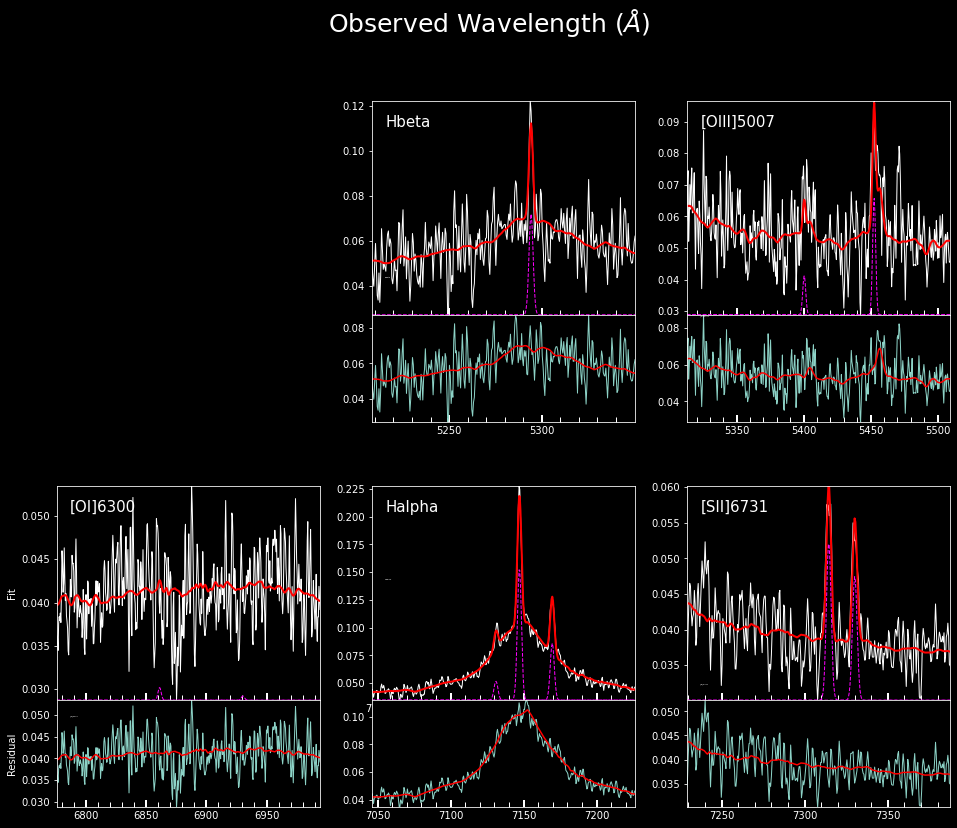

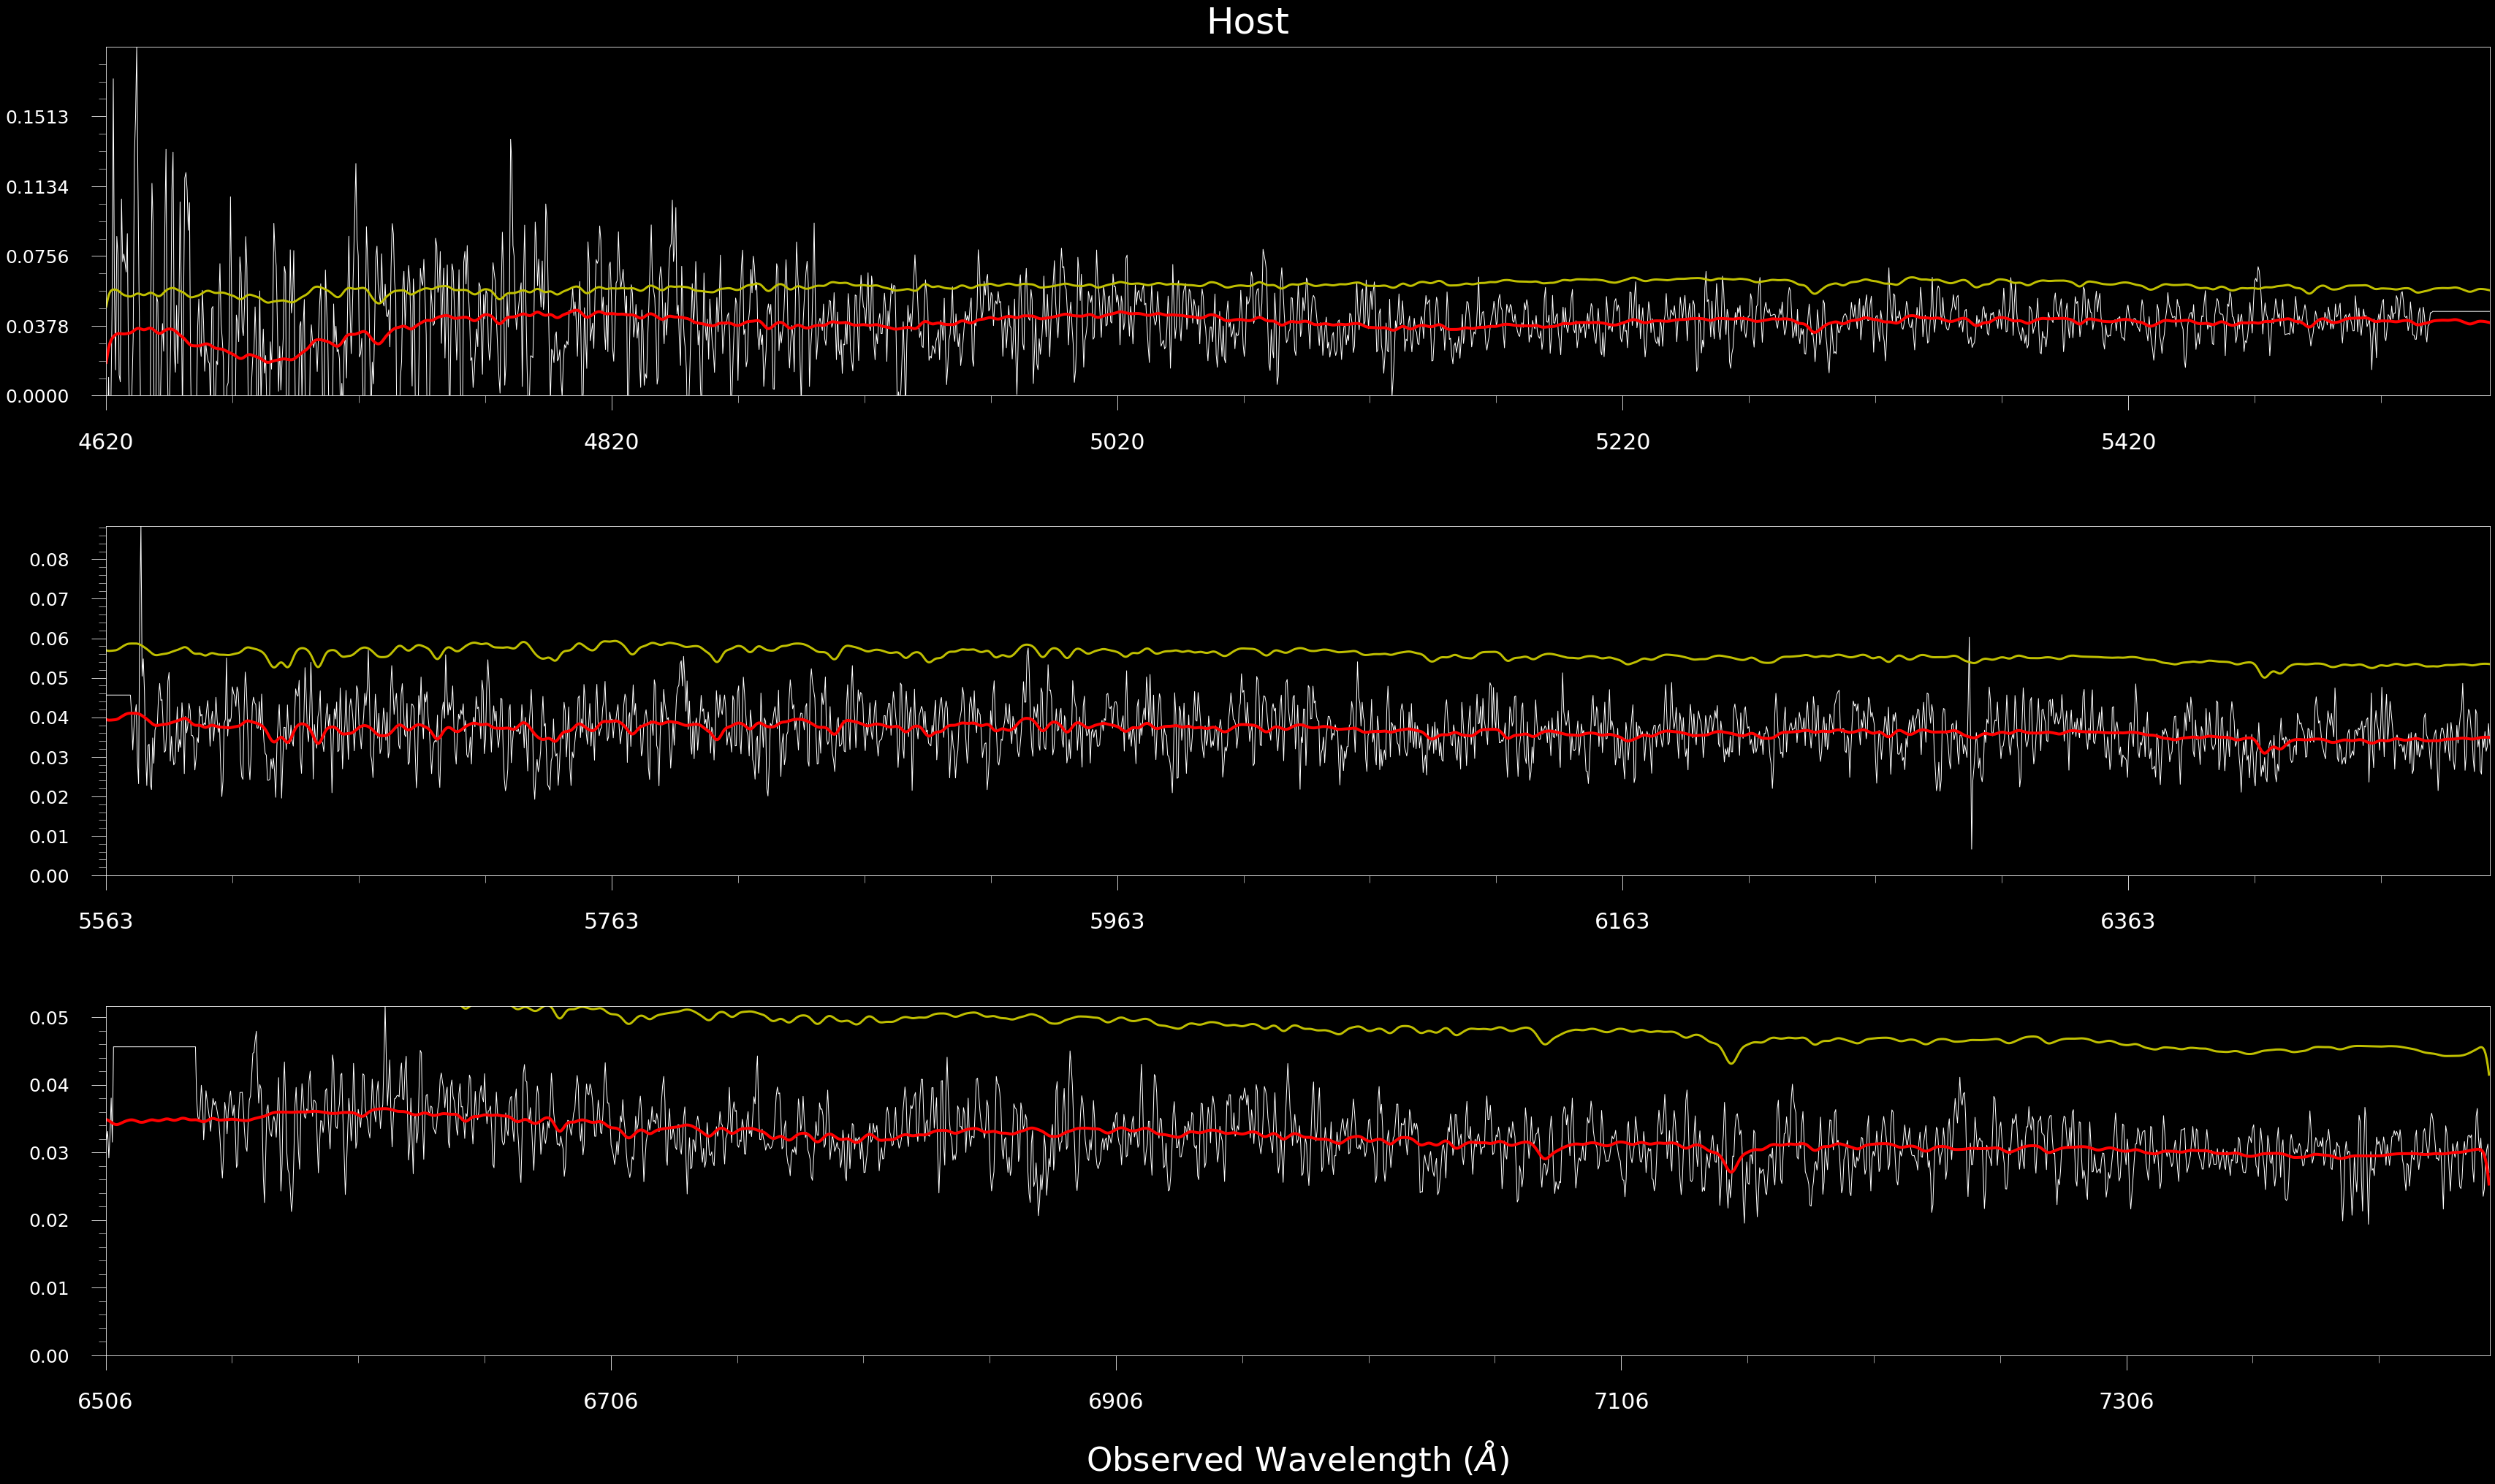

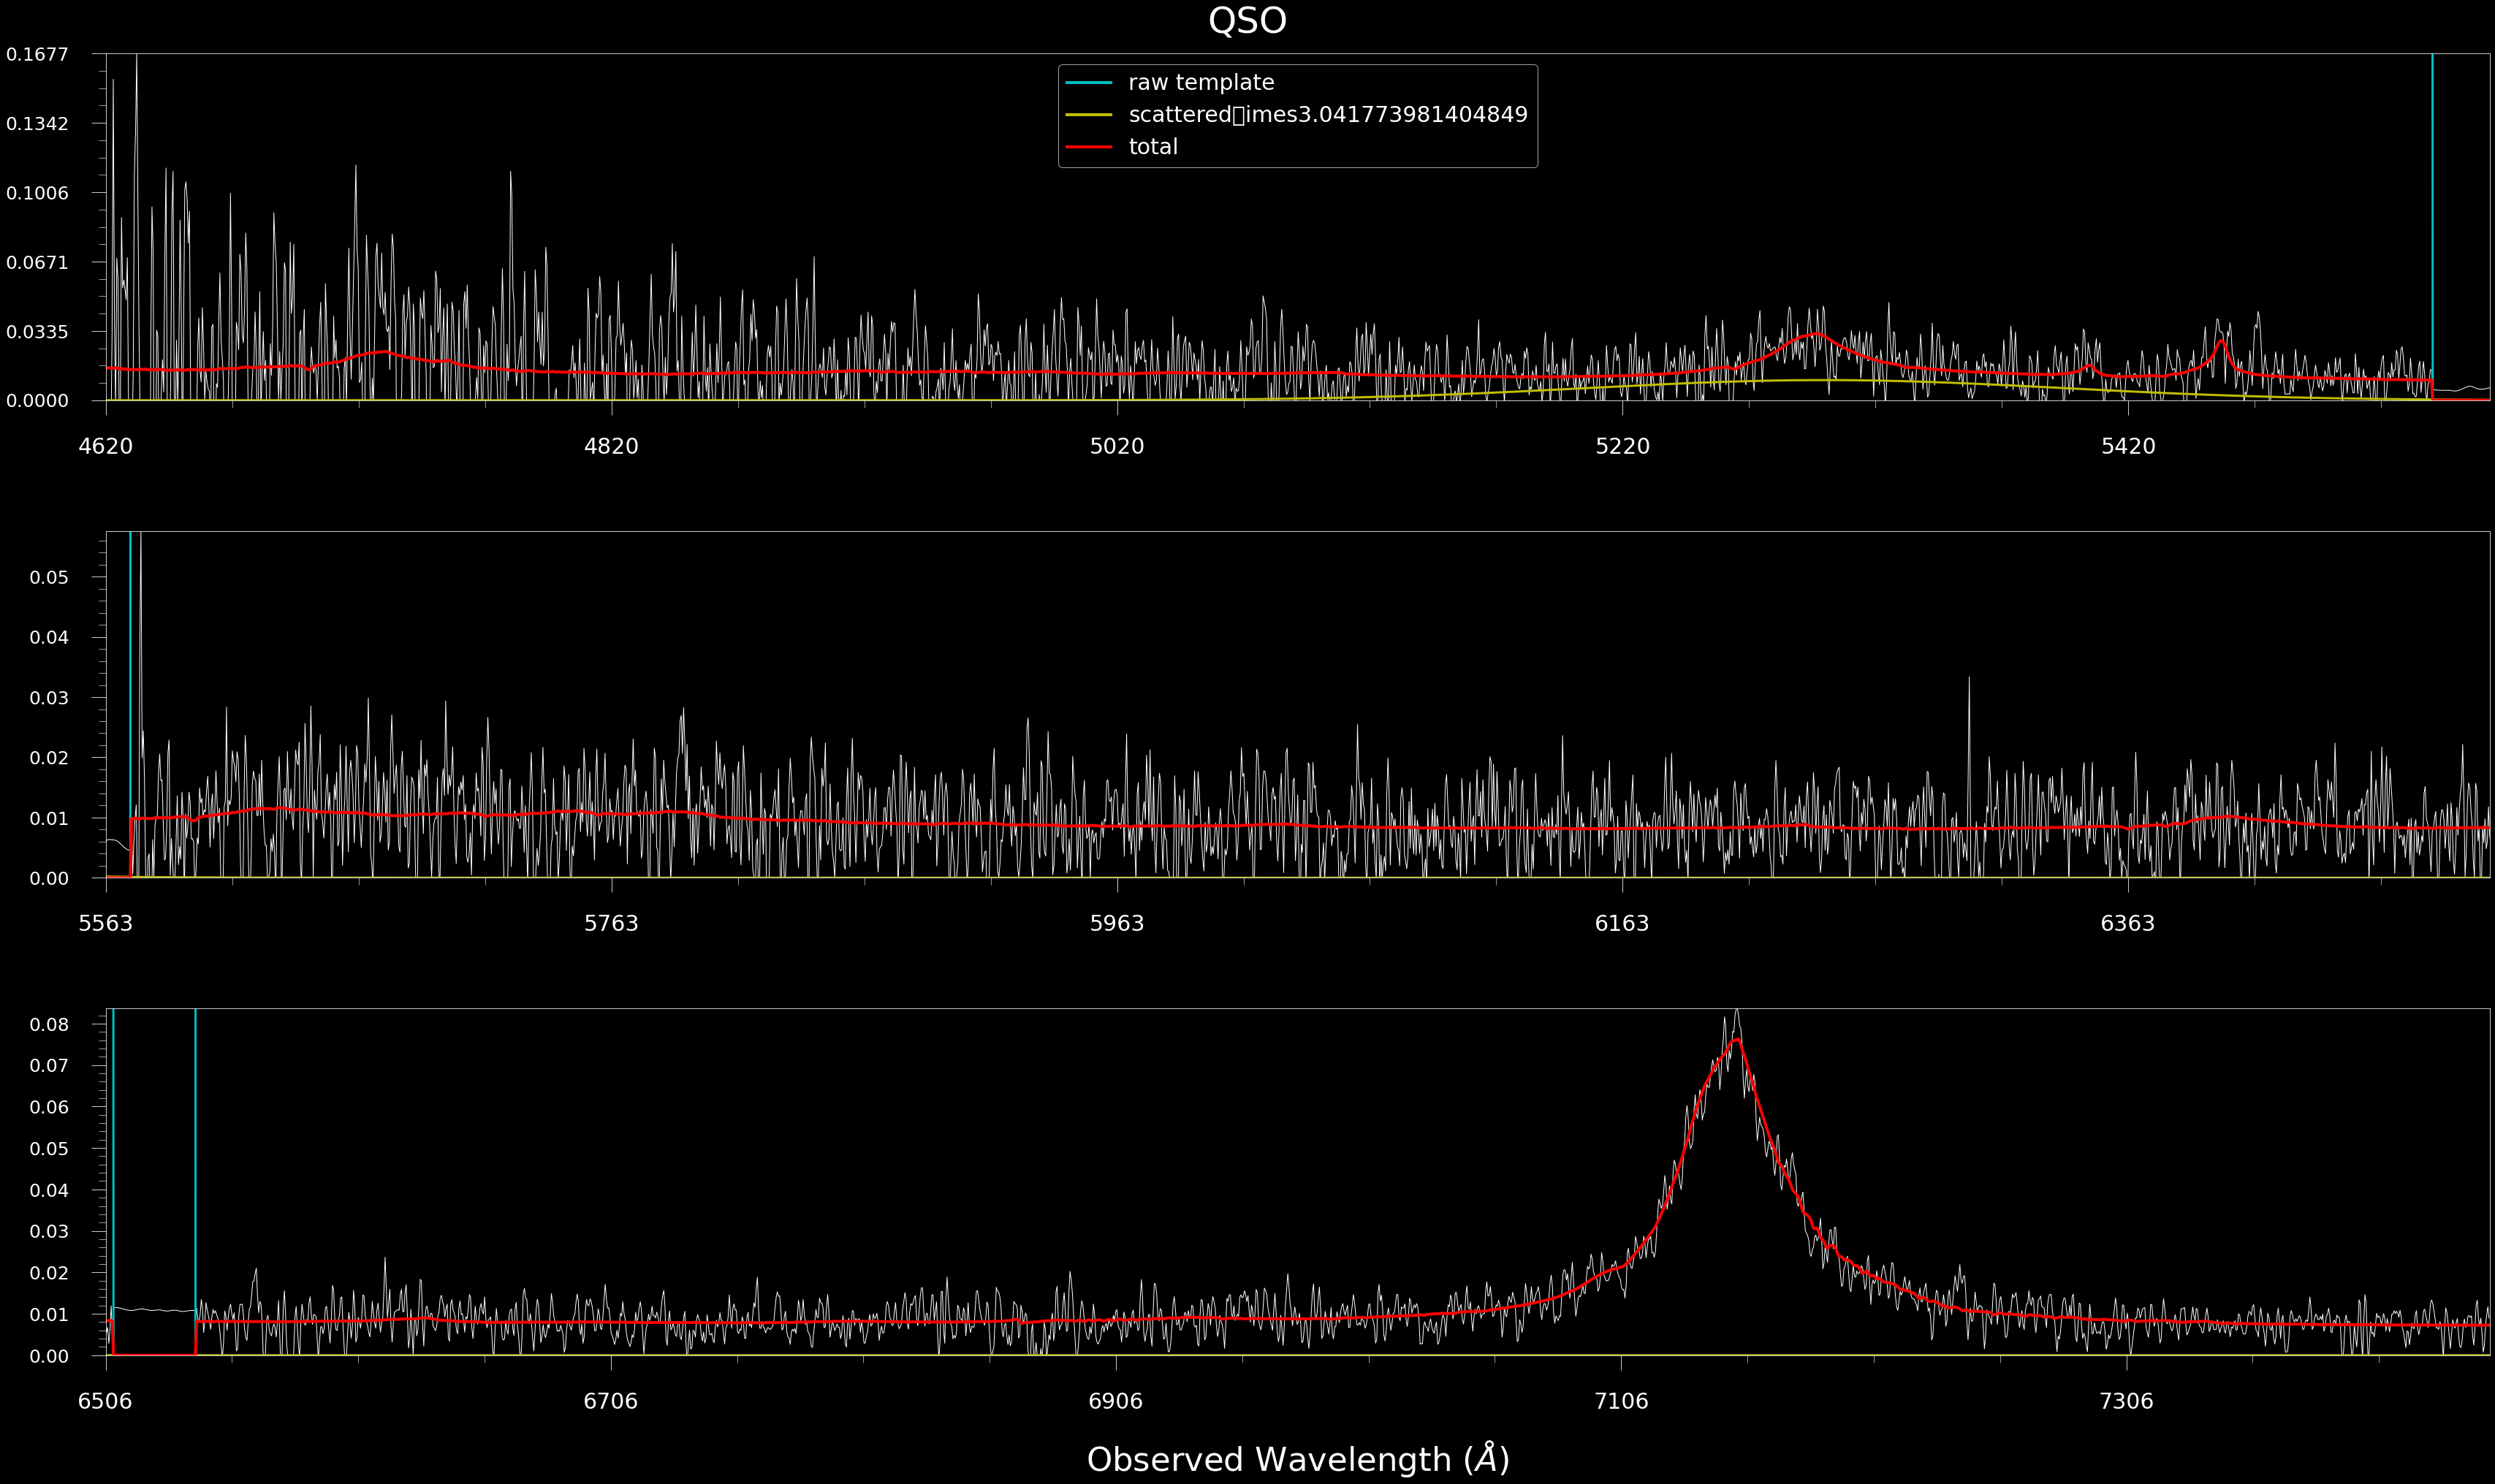

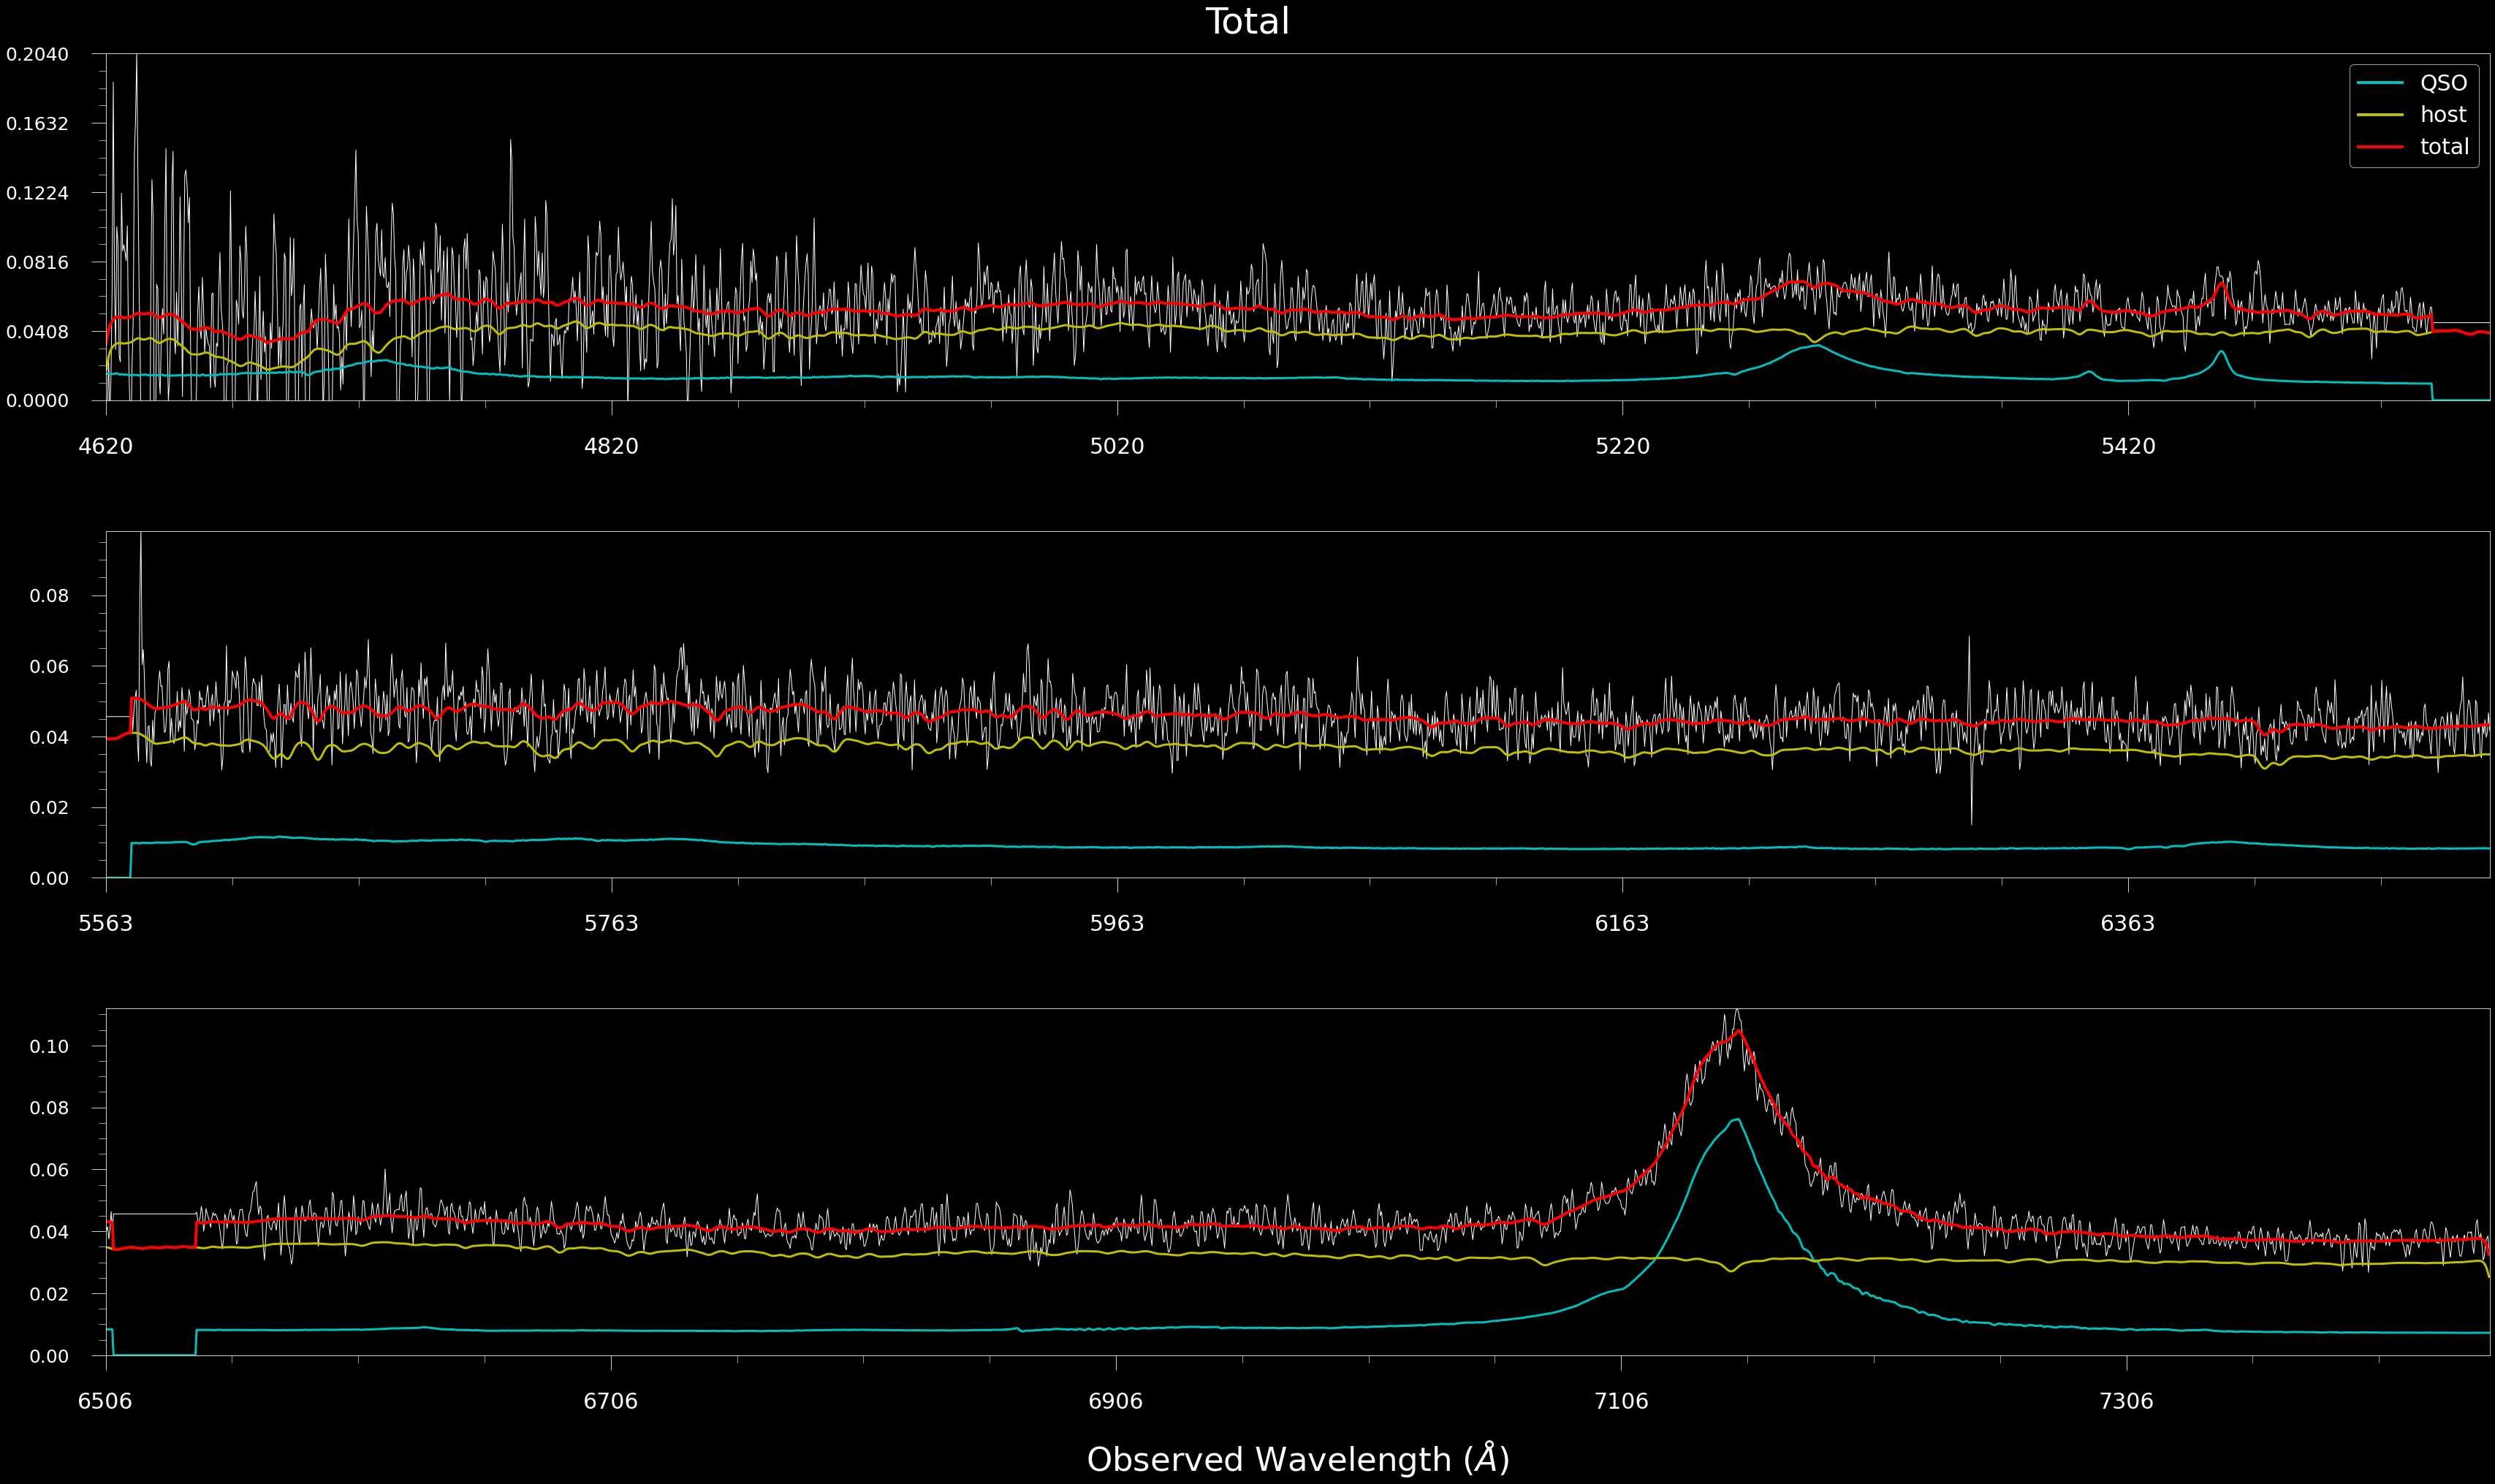

In [6]:
q3da(initproc,cols=cols,rows=rows)